In [ ]:
# !python -m venv env 
# !python -m pip install --upgrade pip
# !pip install tensorflow
# !pip install -U imbalanced-learn
# !pip install sklearn



### (Opcional) Redimensionar imágenes 

In [4]:
import cv2
import os

input_folder = "./classes_poses/"
output_folder = "./classes_poses_red/"
new_size = (224, 224)

for root, dirs, files in os.walk(input_folder):
    relative_path = os.path.relpath(root, input_folder)
    output_subfolder = os.path.join(output_folder, relative_path)
    os.makedirs(output_subfolder, exist_ok=True)
    for file in files:
        input_path = os.path.join(root, file)
        output_path = os.path.join(output_subfolder, file)
        img = cv2.imread(input_path)
        resized_img = cv2.resize(img, new_size)
        cv2.imwrite(output_path, resized_img)

## Grafico de una seña para cada clase

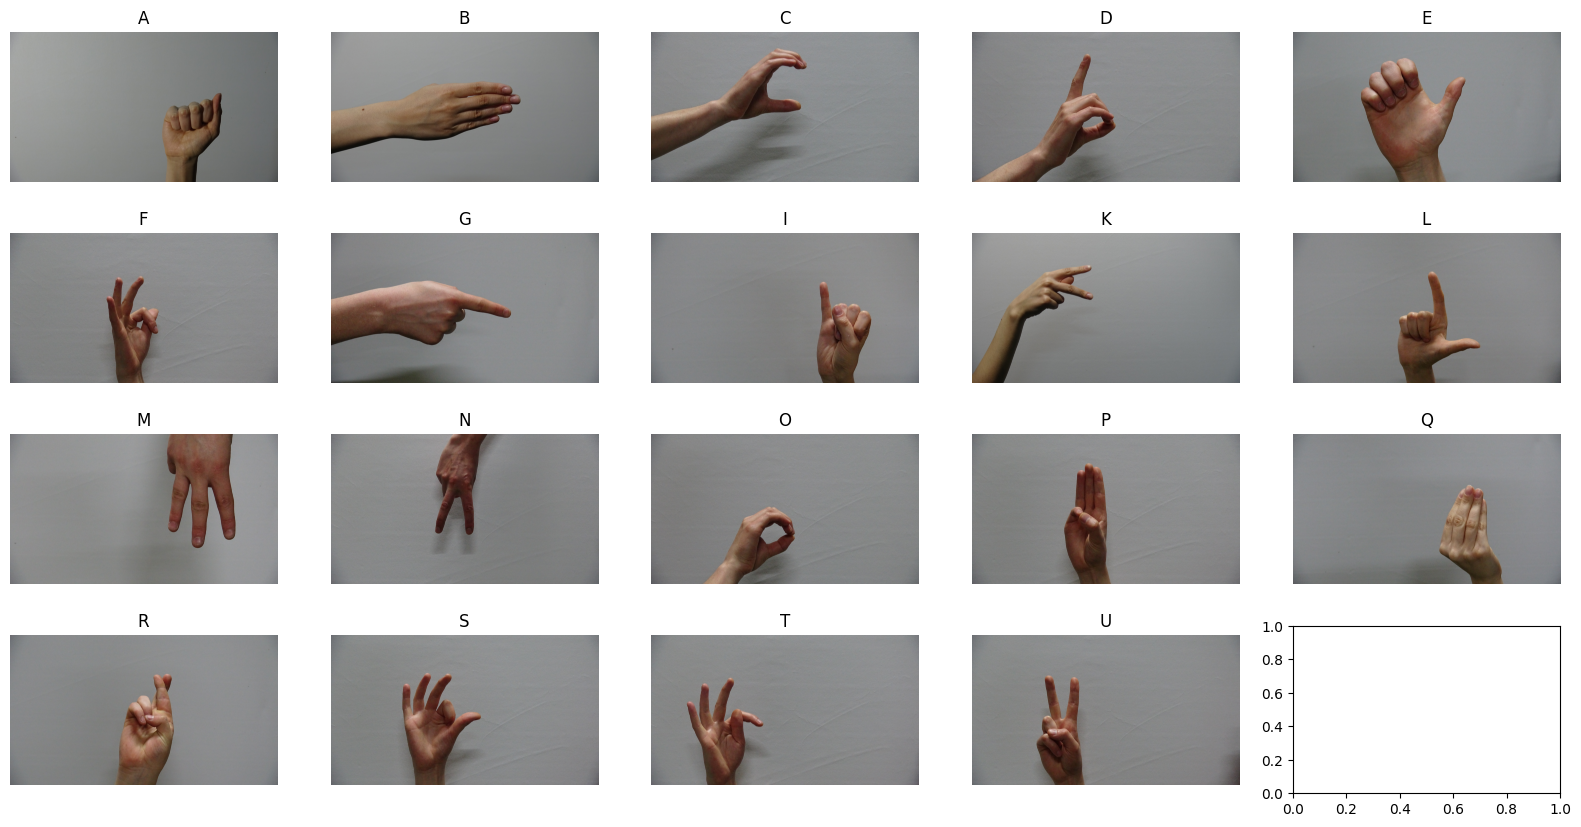

In [4]:
import matplotlib.pyplot as plt
import os
import random
from matplotlib import image as mpimg
import json

class_indices = json.load(open('class_indices.json'))
classes = list(class_indices.keys())
fig, axes = plt.subplots(4, 5, figsize=(20, 10))

for i in range(min(len(classes), 19)):
    class_name = classes[i]
    img_name = random.choice(os.listdir(f'./classes_original/{class_name}'))
    img_path = f'./classes_original/{class_name}/{img_name}'
    
    img = mpimg.imread(img_path)
    
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(class_name)
    axes[i // 5, i % 5].axis('off')

plt.show()


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(ax, channel, title):
    ax.hist(channel.ravel(), bins=256, color='blue', alpha=0.7)
    ax.set_title(title)
    ax.set_xlim(0, 256)

img = cv2.imread("./classes/A/DSC00882.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

axes[0, 0].imshow(img)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Plot histograms before normalization
for i in range(3):
    channel = img[:, :, i]
    plot_histogram(axes[0, i + 1], channel, f'Canal {i}')

# Normalize the image
img_normalized = np.zeros_like(img, dtype=np.float32)

for i in range(3):  # Iterate over RGB channels
    channel = img[:, :, i] / 255.0  # Normalize to [0, 1]

    mean_channel = np.mean(channel)
    std_channel = np.std(channel)

    img_normalized[:, :, i] = np.divide((channel - mean_channel), std_channel, out=np.zeros_like(channel), where=std_channel != 0)

# Clip values to the valid range [0, 1] for display
img_normalized = np.clip(img_normalized, 0, 1)

axes[1, 0].imshow(img_normalized)
axes[1, 0].set_title('Normalized')
axes[1, 0].axis('off')

# Plot histograms after normalization
for i in range(3):
    channel_normalized = img_normalized[:, :, i]
    plot_histogram(axes[1, i + 1], channel_normalized, f'Canal {i} Normalizado')

plt.show()


SyntaxError: invalid syntax (1315548623.py, line 1)

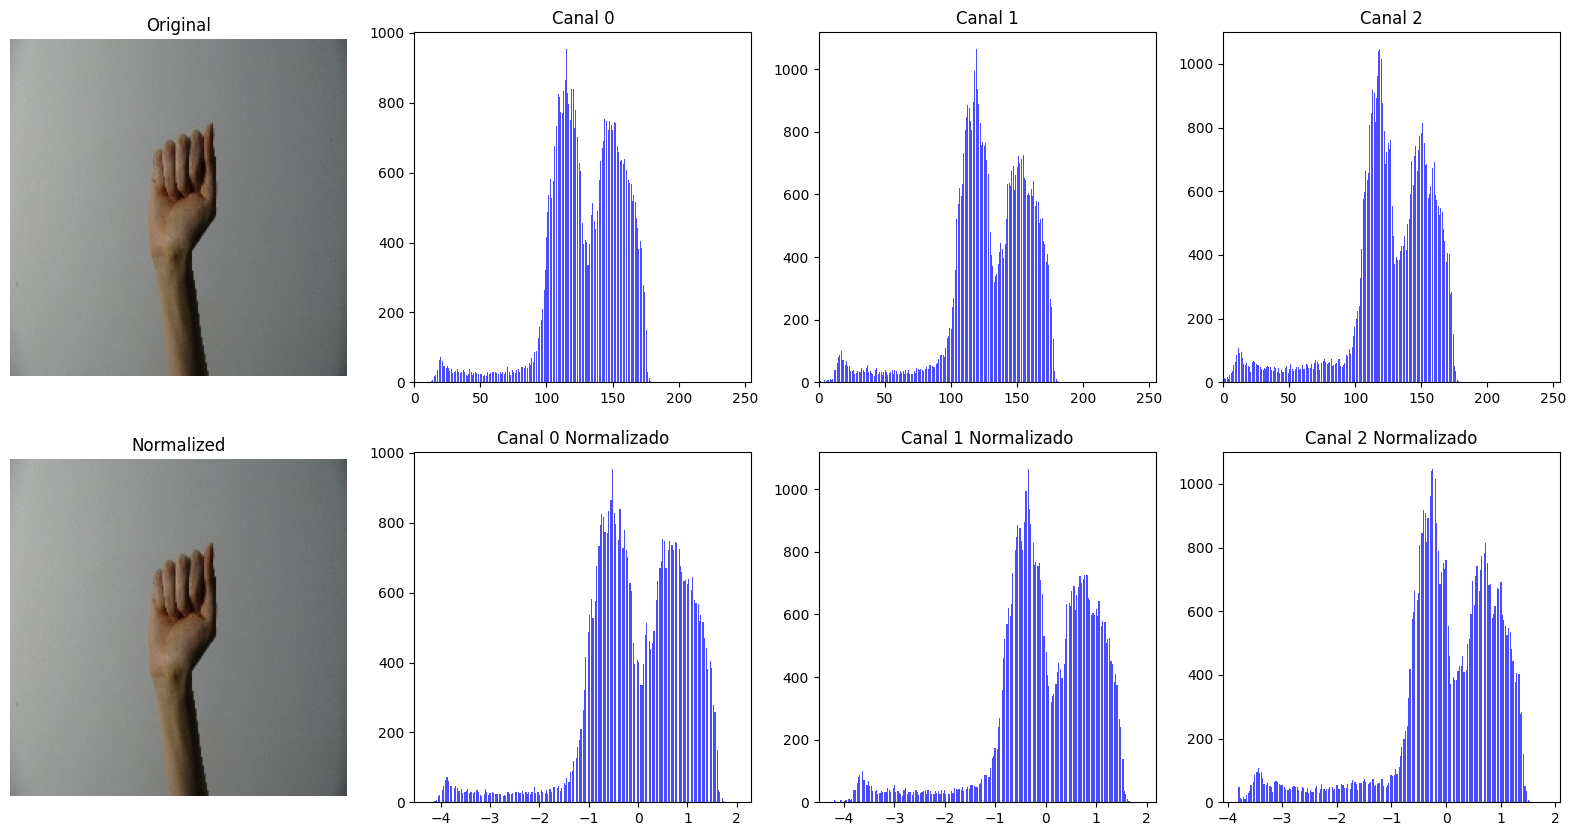

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(ax, channel, title, xlim=None):
    ax.hist(channel.ravel(), bins=256, color='blue', alpha=0.7)
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)

img = cv2.imread("./classes/A/DSC00882.JPG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

axes[0, 0].imshow(img)
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Plot histograms before normalization
for i in range(3):
    channel = img[:, :, i]
    plot_histogram(axes[0, i + 1], channel, f'Canal {i}', xlim=(0, 255))

# Normalize the image after generating histograms
img_normalized = img.astype(np.float32) / 255.0

axes[1, 0].imshow(np.clip(img_normalized, 0, 1))
axes[1, 0].set_title('Normalized')
axes[1, 0].axis('off')

# Plot histograms after normalization
for i in range(3):
    channel_normalized = (img_normalized[:, :, i] - np.mean(img_normalized[:, :, i])) / np.std(img_normalized[:, :, i])
    plot_histogram(axes[1, i + 1], channel_normalized, f'Canal {i} Normalizado')

plt.show()


## Definición de los estimadores de pose

restarle a cada canart por separado la media del canal y dividir por la desviación estandar, garantizo ma media de o y desviacion estandar de 1

tener canal el grises
aumentar el tamaño de lo spuntos y grosor del as lineas 
adquirir criterios para seleccionar los parametros


In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Función para dibujar puntos de la pose del cuerpo
def draw_pose_landmarks(frame, landmarks, COLOR):
    height, width, _ = frame.shape
    for point in landmarks.landmark:
        x, y = int(point.x * width), int(point.y * height)
        cv2.circle(frame, (x, y), 5, COLOR, -1)


# Función para dibujar puntos y líneas de las manos
def draw_hand_landmarks(frame, landmarks,):
    height, width, _ = frame.shape
    for i, point in enumerate(landmarks.landmark):
        x, y = int(point.x * width), int(point.y * height)
        color = (0, 255, 0) if i % 4 == 0 else (0, 0, 255)
        cv2.circle(frame, (x, y), int(height * 0.01), color, -1)

    connections = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 5], [5, 6], [6, 7], [7, 8], [0, 9], [9, 10], [10, 11], [11, 12], [0, 13], [13, 14], [14, 15], [15, 16], [0, 17], [17, 18], [18, 19], [19, 20]]
    for connection in connections:
        cv2.line(frame, (int(landmarks.landmark[connection[0]].x * width), int(landmarks.landmark[connection[0]].y * height)),
                 (int(landmarks.landmark[connection[1]].x * width), int(landmarks.landmark[connection[1]].y * height)), BLUE, 2)

# Función para dibujar cuadro de la cara
def draw_face_detection(frame, detections, COLOR):
    height, width, _ = frame.shape
    for detection in detections:
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = frame.shape
        bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
        cv2.rectangle(frame, bbox, COLOR, 2)

# Inicializar los modelos de MediaPipe
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_face = mp.solutions.face_detection

pose = mp_pose.Pose()
hands = mp_hands.Hands()
face_detection = mp_face.FaceDetection()

# Constantes para colores
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)


## Creación de dataset de poses

In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np

# Inicializar los modelos de MediaPipe
mp_hands = mp.solutions.hands

# Constantes para colores
BLUE = (255, 0, 0)



# Especificar la ruta de la carpeta de origen y destino
origen_carpeta = './classes_original/'
destino_carpeta = './classes_poses/'

# Inicializar el modelo de manos
hands = mp_hands.Hands()

# Recorrer la estructura de carpetas y archivos
for ruta_actual, _, archivos in os.walk(origen_carpeta):
    for archivo in archivos:
        clase = os.path.basename(ruta_actual)
        ruta_archivo = os.path.join(ruta_actual, archivo)
        
        frame = cv2.imread(ruta_archivo)
        
        if frame is None:
            print(f"No se pudo leer la imagen: {ruta_archivo}")
            continue  

        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        hands_results = hands.process(img)
        black_frame = np.zeros_like(frame)

        if hands_results.multi_hand_landmarks:
            for landmarks in hands_results.multi_hand_landmarks:
                draw_hand_landmarks(black_frame, landmarks)

        archivo_nombre = os.path.basename(ruta_archivo)
        print(f"{clase} - {archivo_nombre} - {destino_carpeta}")
        destino = f"{destino_carpeta}/{clase}"

        os.makedirs(destino, exist_ok=True)
        # Guardar la imagen procesada en color
        cv2.imwrite(f"{destino}/{archivo_nombre}", black_frame)

# Cerrar la instancia del modelo de manos
hands.close()
